In [ ]:
%reload_ext autoreload
%autoreload 2

import os
from glob import glob

import numpy as np
from tqdm import tqdm

## Convert from NIfTI format to Numpy Arrays

In [ ]:
"""
    Convert all .nii.gz files to .npy arrays
"""

from monai.transforms import CropForegroundd, EnsureChannelFirstD, LoadImaged, Orientationd, Compose, \
    RandCropByPosNegLabeld

NIB_EXT = ".nii.gz"
DATA_DIR = "data/ATLAS_2/Training"
OUTPUT_SCAN_DIR = "data/ATLAS_2/Processed/Scans"
OUTPUT_MASK_DIR = "data/ATLAS_2/Processed/Masks"

os.makedirs(OUTPUT_SCAN_DIR, exist_ok=True)
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

scans_filepaths = sorted(glob(os.path.join(DATA_DIR, "**/*_T1w" + NIB_EXT), recursive=True))
masks_filepaths = sorted(glob(os.path.join(DATA_DIR, "**/*T1lesion_mask" + NIB_EXT), recursive=True))

assert len(masks_filepaths) == len(scans_filepaths), "Length of masks and scans does not match"

# add channel dimension as the first axis, keep MRI orientation, crop the brain bounding box to exclude non-informative pixels
# images will be reshaped to (1, 192, 192, 189) - (C, H, W, D)
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstD(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    RandCropByPosNegLabeld(keys=["image", "label"], num_samples=1, spatial_size=(192, 192, -1), pos=1, neg=1,
                           label_key="label"),
])

for scan_filepath, mask_filepath in tqdm(zip(scans_filepaths, masks_filepaths),
                                         total=len(scans_filepaths), desc=f"Converting from {NIB_EXT} to .npy"):
    results = transforms({"image": scan_filepath, "label": mask_filepath})

    scan, mask = results[0]["image"], results[0]["label"]

    output_scan_filepath = scan_filepath.split("/")[-1].split(".")[0] + ".npy"
    output_mask_filepath = mask_filepath.split("/")[-1].split(".")[0] + ".npy"

    np.save(os.path.join(OUTPUT_SCAN_DIR, output_scan_filepath), scan)  # noqa
    np.save(os.path.join(OUTPUT_MASK_DIR, output_mask_filepath), mask)  # noqa


## Dataset Split (Parameter tuning)

We split the dataset into a 80-10-10 manner. This split will be used for hyperparameter tuning

In [ ]:
import os
from glob import glob

import pandas as pd

from utils import get_lesion_distribution_metadata, plot_lesion_size_distribution, plot_fold_distribution, round_half_up
from constants import LESION_SIZES

DEPTH = 189
SEED = 42
OUTPUT_MASK_DIR = "data/ATLAS_2/Processed/Masks"
masks_filepaths = sorted(glob(os.path.join(OUTPUT_MASK_DIR, "*T1lesion_mask.npy"), recursive=True))

metadata = get_lesion_distribution_metadata(masks_filepaths)
counts_across_slices = [metadata[size]["count"] for size in LESION_SIZES]

size_distributions = plot_lesion_size_distribution(counts_across_slices, LESION_SIZES, return_distribution=True)

dataframe_data = [{"size": size, "filepath": fp[0]} for size in LESION_SIZES for fp in metadata[size]["filepaths"]]
df = pd.DataFrame(dataframe_data)

# compute volume-level distribution
volume_dist = (
    df.groupby("filepath")["size"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# ensure 'filepath' is preserved
volume_dist.to_csv("volume_dist.csv")
volume_dist = pd.read_csv("volume_dist.csv")
os.remove("volume_dist.csv")

volume_dist = volume_dist.sample(frac=1, random_state=SEED)

total_slices = len(volume_dist) * DEPTH

assigned = set()
splits = {
    "train": {
        "percentage": 0.80,
        "indexes": [],
    },
    "val": {
        "percentage": 0.10,
        "indexes": [],
    },
    "test": {
        "percentage": 0.10,
        "indexes": [],
    }
}

for split in splits.keys():
    volumes_per_split = round_half_up(total_slices * splits[split]["percentage"])
    fold_target = {k: volumes_per_split * v // 100 for k, v in size_distributions.items()}

    for filepath, row in volume_dist.iterrows():
        if filepath in assigned:
            continue

        contrib = {k: row.get(k, 0) * DEPTH for k in size_distributions.keys()}
        if any(v > 0 for v in fold_target.values()):
            splits[split]["indexes"].append(filepath)
            assigned.add(filepath)
            for k in fold_target.keys():
                fold_target[k] = max(0, fold_target[k] - contrib[k])

train_masks_paths = list(volume_dist.loc[splits["train"]["indexes"]].filepath)
val_masks_paths = list(volume_dist.loc[splits["val"]["indexes"]].filepath)
test_masks_paths = list(volume_dist.loc[splits["test"]["indexes"]].filepath)

plot_fold_distribution(train_masks_paths, title=f"Train set distribution")
plot_fold_distribution(val_masks_paths, title=f"Val set distribution")
plot_fold_distribution(test_masks_paths, title=f"Test set distribution")

In [ ]:
import os
import shutil

from tqdm import tqdm

OUTPUT_DIR = "data/ATLAS_2/Processed/Splits/"
SPLITS = {
    "Train": train_masks_paths,
    "Val": val_masks_paths,
    "Test": test_masks_paths,
}

os.makedirs(OUTPUT_DIR, exist_ok=True)

for split, masks_filepaths in SPLITS.items():
    split_dir = os.path.join(OUTPUT_DIR, split)
    split_masks_dir = os.path.join(split_dir, "Masks")
    split_scans_dir = os.path.join(split_dir, "Scans")

    os.makedirs(split_masks_dir, exist_ok=True)
    os.makedirs(split_scans_dir, exist_ok=True)

    for mask_filepath in tqdm(masks_filepaths, desc=f"Creating {split} set"):
        scan_filepath = mask_filepath.replace("Masks", "Scans").replace("label-L_desc-T1lesion_mask", "T1w")

        shutil.copy(mask_filepath, os.path.join(split_masks_dir, mask_filepath.split(os.path.sep)[-1]))  # noqa
        shutil.copy(scan_filepath, os.path.join(split_scans_dir, scan_filepath.split(os.path.sep)[-1]))  # noqa

print(
    f"Train split: {len(train_masks_paths)}\nValidation split: {len(val_masks_paths)}\nTest split: {len(test_masks_paths)}")

## Augmentation: CarveMix + Ecological

In [ ]:
"""
    1. Find lesion and non-lesion slices that have closely head masks
    2. Refine the previous step to slices that have the most similar shape/size to lesion slices through IoU
    3. Calculate Structural Similarity Index (SSIM) to refine the previous step. Images with an high SSIM should have a similar vasculature structure
    4. Select the lesion and apply some morphological modification (e.g., contract, expand, rotate)
    5. Standardize intensities to smooth lesion integration
"""

In [ ]:
import os
from glob import glob

import numpy as np
import torch

from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

SCANS_DIR = "data/ATLAS_2/Processed/Scans"
MASKS_DIR = "data/ATLAS_2/Processed/Masks"

# preload scans and masks as tensors for speeding up operations
scans_filepaths = sorted(glob(os.path.join(SCANS_DIR, "*.npy")))
masks_filepaths = sorted(glob(os.path.join(MASKS_DIR, "*.npy")))

volumes = []

for scan_filepath, mask_filepath in tqdm(zip(scans_filepaths, masks_filepaths), desc="Preloading volumes"):
    scan = np.load(scan_filepath)  # (1, H, W, D)
    mask = np.load(mask_filepath)

    scan = torch.from_numpy(scan).to(device=device)
    mask = torch.from_numpy(mask).to(device=device)

    volumes.append((scan_filepath, mask_filepath, scan, mask))

In [228]:
import torch
import re

from torchmetrics.functional.image.ssim import structural_similarity_index_measure as ssim


def compute_head_mask(scan: torch.Tensor) -> torch.Tensor:
    # Assumes scan tensor is intensity image, mask where intensity <= 8 (arbitrary threshold)
    return scan > 8


def compare_head_sizes(sick_head_masks: torch.Tensor, healthy_head_masks: torch.Tensor,
                       threshold: float = 0.20) -> torch.Tensor:
    assert 0 <= threshold <= 1, "threshold must be between 0 and 1"

    if sick_head_masks.dtype != torch.bool:
        sick_head_masks = compute_head_mask(sick_head_masks)
    if healthy_head_masks.dtype != torch.bool:
        healthy_head_masks = compute_head_mask(healthy_head_masks)

    total_area = torch.tensor(sick_head_masks.shape[-3] * sick_head_masks.shape[-2],
                              device=sick_head_masks.device).float()

    # shape [N_sick]
    sick_head_masks_sum = sick_head_masks.float().sum(dim=(0, 1, 2))
    # shape [N_healthy]
    healthy_head_masks_sum = healthy_head_masks.float().sum(dim=(0, 1, 2))

    sick_head_masks_area = sick_head_masks_sum / total_area.repeat(sick_head_masks.shape[-1])
    healthy_head_masks_area = healthy_head_masks_sum / total_area.repeat(healthy_head_masks.shape[-1])

    # compute pairwise absolute differences (broadcasting)
    # sick_areas: [N_sick] → [N_sick, 1]
    # healthy_areas: [N_healthy] → [1, N_healthy]
    sick_head_masks_area = sick_head_masks_area.unsqueeze(-1)
    healthy_head_masks_area = healthy_head_masks_area.unsqueeze(0)
    abs_diff = (sick_head_masks_area - healthy_head_masks_area).abs()

    return abs_diff <= threshold


def compute_pairwise_iou(A, B):
    A = A.unsqueeze(-1)  # [..., N_sick] -> [..., N_sick, 1]
    B = B.unsqueeze(-2)  # [..., N_healthy] -> [..., 1, N_healthy]

    intersection = (A & B).sum(dim=(0, 1, 2))
    union = (A | B).sum(dim=(0, 1, 2))

    return intersection / (union + 1e-8)  # avoid division by zero


def compare_head_shapes(sick_head_mask: torch.Tensor, healthy_head_mask: torch.Tensor, threshold: float = 0.80) -> bool:
    assert 0 <= threshold <= 1, "threshold must be between 0 and 1"

    if sick_head_mask.dtype != torch.bool:
        sick_head_mask = compute_head_mask(sick_head_mask)
    if healthy_head_mask.dtype != torch.bool:
        healthy_head_mask = compute_head_mask(healthy_head_mask)

    iou_score = compute_pairwise_iou(sick_head_mask, healthy_head_mask)
    return iou_score >= threshold


def update_slice_positions(positions, remaining_slices): 
    return {i: positions[r.item()] for i, r in enumerate(remaining_slices)}


def get_patient_id(filepath):
    basename = os.path.basename(filepath)
    prefix = basename.split("_")[0]  # expects 'sub-rXXXsXXX...' format
    return re.split(r"s\d+", prefix)[0]  # extracts 'sub-rXXX'

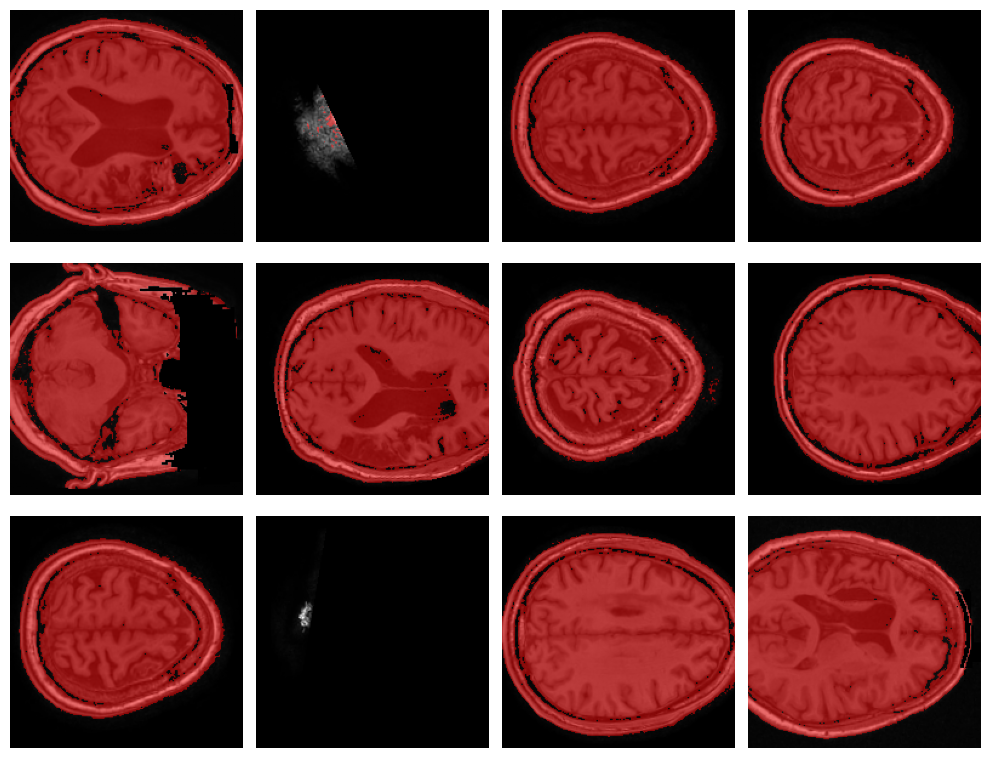

In [135]:
import numpy as np
import random
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8))

for i in range(3):
    for j in range(4):
        slice_idx = random.randint(0, 188)
        scan = np.load(scans_filepaths[i * j])
        slice = scan[0, ..., slice_idx]
        head_mask = compute_head_mask(torch.from_numpy(slice))

        axes[i, j].imshow(slice, cmap="gray")
        red_mask = np.zeros(head_mask.shape + (4,))  # rgba
        red_mask[head_mask, 0] = 1
        red_mask[head_mask, 3] = 0.5
        axes[i, j].imshow(red_mask)
        axes[i, j].axis("off")

fig.tight_layout(h_pad=0.15, w_pad=1)
plt.show()

In [236]:
import os
from tqdm import tqdm
import torch
import torch.nn.functional as F

scanned_pairs = set()
most_similar_pairs = {}
ssim_threshold = 0.3

for (scan_filepath, _, scan, mask) in tqdm(volumes, desc="Finding most similar sick-healthy pairs"):
    patient_id = get_patient_id(scan_filepath)
    sick_slices_mask = mask.any(dim=(0, 1, 2))  # shape (D,)
    sick_slice_indices = torch.argwhere(sick_slices_mask).flatten()
    
    if len(sick_slice_indices) == 0:
        continue
        
    sick_global_indices_map = {i: index.item() for i, index in enumerate(sick_slice_indices)}

    tmp_scan = scan[..., sick_slice_indices]
    scan_basename = os.path.basename(scan_filepath)
    most_similar_pairs[scan_basename] = {}

    for (ot_scan_filepath, _, ot_scan, ot_mask) in volumes:
        ot_patient_id = get_patient_id(ot_scan_filepath)
        paths_pair = (scan_filepath, ot_scan_filepath)
        ot_basename = os.path.basename(ot_scan_filepath)

        if ot_patient_id == patient_id or paths_pair in scanned_pairs or paths_pair[::-1] in scanned_pairs:
            continue

        scanned_pairs.add(paths_pair)

        healthy_slices_mask = ~ot_mask.any(dim=(0, 1, 2))
        healthy_slice_indices = torch.argwhere(healthy_slices_mask).flatten()
        
        if len(healthy_slice_indices) == 0:
            continue
        
        healthy_global_indices_map = {i: index.item() for i, index in enumerate(healthy_slice_indices)}
        ot_scan_filtered = ot_scan[..., healthy_slice_indices]

        # step 1: Size mask comparison - boolean mask of shape [N_sick, N_healthy]
        sizes_scores = compare_head_sizes(tmp_scan, ot_scan_filtered)

        if not sizes_scores.any():
            continue

        true_pairs = torch.nonzero(sizes_scores, as_tuple=False)

        sick_slices = true_pairs[:, 0].unique()
        healthy_slices = true_pairs[:, 1].unique()
        
        sick_global_indices_map = update_slice_positions(sick_global_indices_map, sick_slices)
        healthy_global_indices_map = update_slice_positions(healthy_global_indices_map, healthy_slices)
        
        tmp_scan = tmp_scan[..., sick_slices]
        ot_scan_filtered = ot_scan_filtered[..., healthy_slices]

        # step 2: Shape mask comparison (same slicing)
        shapes_scores = compare_head_shapes(tmp_scan, ot_scan_filtered)
        if not shapes_scores.any():
            continue

        true_pairs = torch.nonzero(shapes_scores, as_tuple=False)

        sick_slices = true_pairs[:, 0].unique()
        healthy_slices = true_pairs[:, 1].unique()
        
        sick_global_indices_map = update_slice_positions(sick_global_indices_map, sick_slices)
        healthy_global_indices_map = update_slice_positions(healthy_global_indices_map, healthy_slices)
        
        tmp_scan = tmp_scan[..., sick_slices]
        ot_scan_filtered = ot_scan_filtered[..., healthy_slices]

        window_size = tmp_scan.shape[-1]
        total_healthy = ot_scan_filtered.shape[-1]

        # sliding window over healthy slices with stride smaller or equal to window size
        stride = window_size

        for start in range(0, total_healthy, stride):
            end = min(start + window_size, total_healthy)
            healthy_window = ot_scan_filtered[..., start:end]

            if healthy_window.shape[-1] < window_size:
                pad_amount = window_size - healthy_window.shape[-1]
                pad_dims = (0, pad_amount) + (0, 0) * (healthy_window.dim() - 1)
                healthy_window = F.pad(healthy_window, pad_dims, "constant", 0)

            # SSIM map: result shape should be [C, H, W, window_size]
            _, full_ssim_map = ssim(tmp_scan, healthy_window, return_full_image=True)

            # remove padded positions from SSIM map
            if healthy_window.shape[-1] > end - start:
                full_ssim_map = full_ssim_map[..., :end - start]

            # average SSIM over spatial dims (C, H, W)
            ssim_scores = full_ssim_map.mean(dim=(0, 1, 2))

            valid_pairs_mask = ssim_scores >= ssim_threshold
            valid_indices = torch.nonzero(valid_pairs_mask, as_tuple=False).flatten()

            # record the matched pair mapping back to original indices
            for i in valid_indices:
                sick_global_idx = sick_global_indices_map[i.item()]
                if sick_global_idx not in most_similar_pairs[scan_basename]:
                    most_similar_pairs[scan_basename][sick_global_idx] = {}
                    
                if ot_basename not in most_similar_pairs[scan_basename][sick_global_idx]:
                    most_similar_pairs[scan_basename][sick_global_idx][ot_basename] = []
                
                healthy_global_idx = healthy_global_indices_map[start + i.item()]
                most_similar_pairs[scan_basename][sick_global_idx][ot_basename].append(healthy_global_idx)

Finding most similar sick-healthy pairs: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


In [237]:
most_similar_pairs

{'sub-r001s001_ses-1_space-MNI152NLin2009aSym_T1w.npy': {72: {'sub-r002s001_ses-1_space-MNI152NLin2009aSym_T1w.npy': [49],
   'sub-r002s004_ses-1_space-MNI152NLin2009aSym_T1w.npy': [52],
   'sub-r002s005_ses-1_space-MNI152NLin2009aSym_T1w.npy': [49]},
  73: {'sub-r002s001_ses-1_space-MNI152NLin2009aSym_T1w.npy': [50],
   'sub-r002s004_ses-1_space-MNI152NLin2009aSym_T1w.npy': [53],
   'sub-r002s005_ses-1_space-MNI152NLin2009aSym_T1w.npy': [50]},
  74: {'sub-r002s001_ses-1_space-MNI152NLin2009aSym_T1w.npy': [51],
   'sub-r002s004_ses-1_space-MNI152NLin2009aSym_T1w.npy': [54],
   'sub-r002s005_ses-1_space-MNI152NLin2009aSym_T1w.npy': [51]},
  75: {'sub-r002s001_ses-1_space-MNI152NLin2009aSym_T1w.npy': [52],
   'sub-r002s004_ses-1_space-MNI152NLin2009aSym_T1w.npy': [55],
   'sub-r002s005_ses-1_space-MNI152NLin2009aSym_T1w.npy': [52]},
  76: {'sub-r002s001_ses-1_space-MNI152NLin2009aSym_T1w.npy': [53],
   'sub-r002s004_ses-1_space-MNI152NLin2009aSym_T1w.npy': [56],
   'sub-r002s005_ses-1_sp

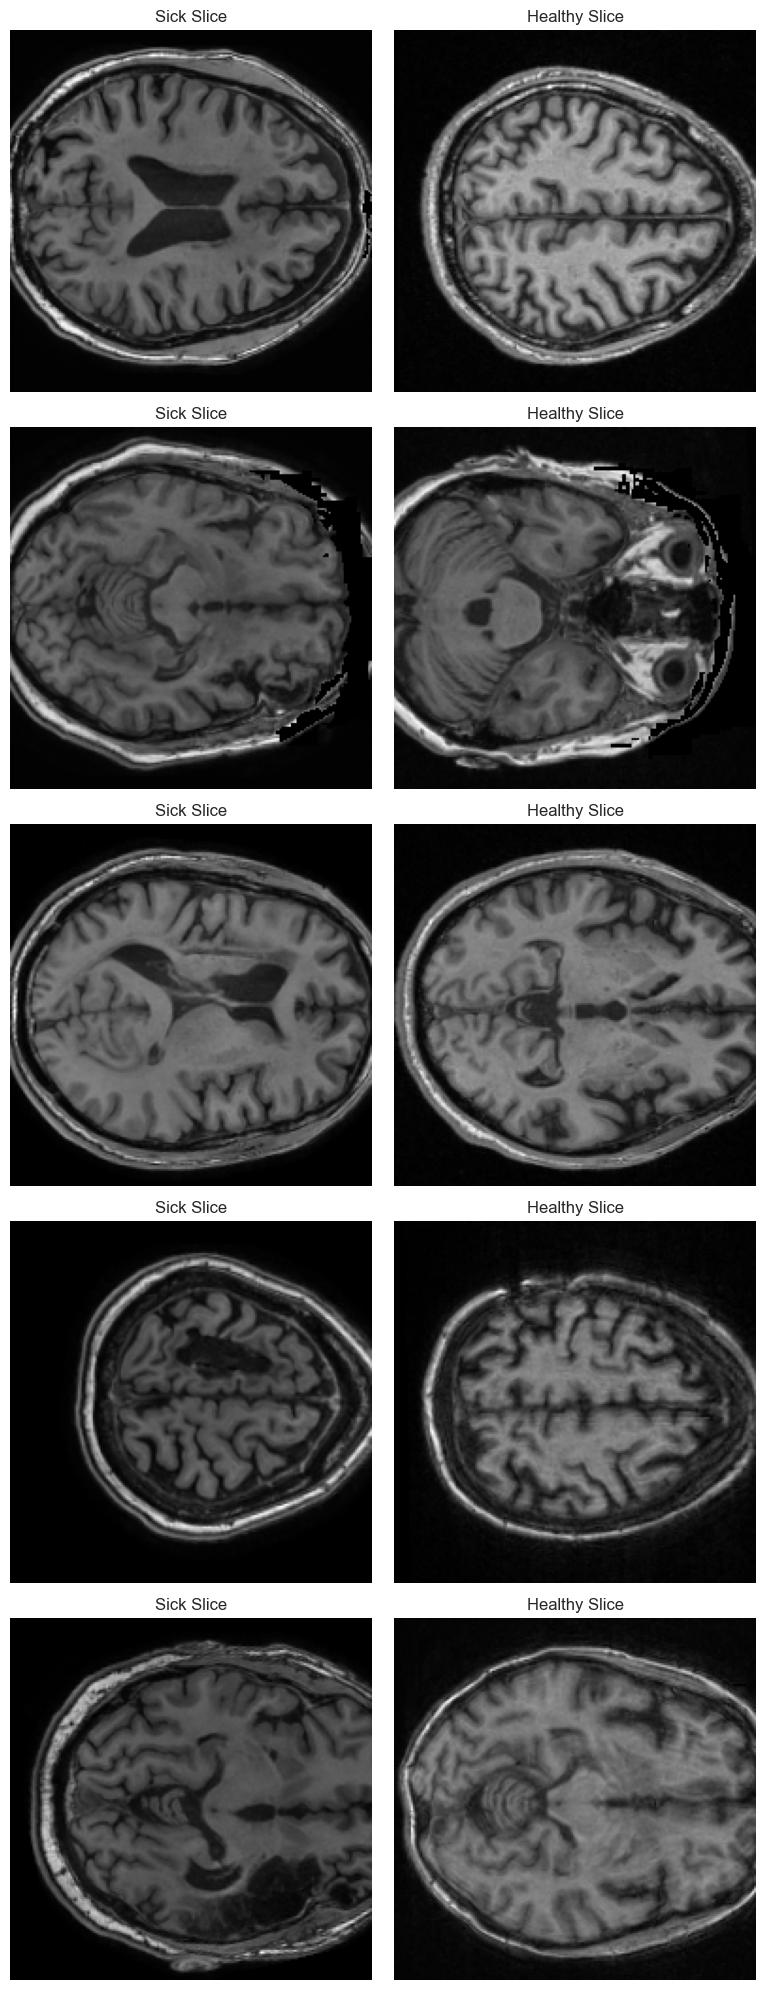

In [255]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np

def load_slice(volume_filename, slice_idx):
    volume = np.load(volume_filename)
    if volume.ndim == 4:
        return volume[0, ..., slice_idx]
    else:
        return volume[..., slice_idx]

def plot_random_pairs_side_by_side(most_similar_pairs, n_pairs=5, data_dir="data/ATLAS_2/Processed/Scans"):
    volume_keys = list(most_similar_pairs.keys())
    selected_volumes = random.sample(volume_keys, min(n_pairs*2, len(volume_keys)))  # oversample to skip empty

    fig, axes = plt.subplots(n_pairs, 2, figsize=(8, 4 * n_pairs))
    if n_pairs == 1:
        axes = axes.reshape((1, 2))

    i = 0
    for vol_key in selected_volumes:
        if i >= n_pairs:
            break
        
        sick_slices_dict = most_similar_pairs.get(vol_key, {})
        if not sick_slices_dict:
            continue
        
        sick_slices_keys = list(sick_slices_dict.keys())
        if not sick_slices_keys:
            continue
        
        sick_slice_key = random.choice(sick_slices_keys)
        healthy_dict = sick_slices_dict[sick_slice_key]
        if not healthy_dict:
            continue
        
        sick_img = load_slice(os.path.join(data_dir, vol_key), sick_slice_key)
        axes[i, 0].imshow(sick_img, cmap='gray')
        axes[i, 0].set_title(f"Sick Slice")
        axes[i, 0].axis('off')

        first_healthy_vol = next(iter(healthy_dict.keys()))
        first_healthy_slice = healthy_dict[first_healthy_vol][0]
        healthy_img = load_slice(os.path.join(data_dir, first_healthy_vol), first_healthy_slice)

        axes[i, 1].imshow(healthy_img, cmap='gray')
        axes[i, 1].set_title(f"Healthy Slice")
        axes[i, 1].axis('off')

        i += 1

    # hide any remaining unused rows
    for j in range(i, n_pairs):
        axes[j, 0].axis('off')
        axes[j, 1].axis('off')

    plt.tight_layout()
    plt.show()

plot_random_pairs_side_by_side(most_similar_pairs, n_pairs=5)

In [242]:
list(most_similar_pairs.keys())

['sub-r001s001_ses-1_space-MNI152NLin2009aSym_T1w.npy',
 'sub-r001s002_ses-1_space-MNI152NLin2009aSym_T1w.npy',
 'sub-r001s003_ses-1_space-MNI152NLin2009aSym_T1w.npy',
 'sub-r001s004_ses-1_space-MNI152NLin2009aSym_T1w.npy',
 'sub-r001s005_ses-1_space-MNI152NLin2009aSym_T1w.npy',
 'sub-r002s001_ses-1_space-MNI152NLin2009aSym_T1w.npy',
 'sub-r002s002_ses-1_space-MNI152NLin2009aSym_T1w.npy',
 'sub-r002s003_ses-1_space-MNI152NLin2009aSym_T1w.npy',
 'sub-r002s004_ses-1_space-MNI152NLin2009aSym_T1w.npy',
 'sub-r002s005_ses-1_space-MNI152NLin2009aSym_T1w.npy']